In [1]:
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import pickle

2024-10-02 22:06:53.978277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 22:06:54.102811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 22:06:54.103405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 22:06:54.235089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 22:06:55.158087: W tensorflow/compiler/tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (5, 5)
plt.rc('font', size=5)

Num GPUs Available:  0


2024-10-02 22:06:59.013792: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']
qtd_pos = data['qtd_pos']
qtd_neg = data['qtd_neg']

pickle.dump(exemplos_treinamento, file = open("exemplos.pickle", "wb"))
pickle.dump(qtd_pos, file = open("qtd_pos.pickle", "wb"))
pickle.dump(qtd_neg, file = open("qtd_neg.pickle", "wb"))

In [6]:
exemplos_treinamento = pickle.load(open("exemplos.pickle", "rb"))
qtd_pos = pickle.load(open("qtd_pos.pickle", "rb"))
qtd_neg = pickle.load(open("qtd_neg.pickle", "rb"))

In [7]:
sentences = []
pos = []
maxlen = 46

def converteTextoParaTokens(texto : str):
    tokens = list(map(lambda x: str(x).lower(), tokenizer.tokenize(texto)))
    for i in range(len(tokens)):
        if tokens[i].isdigit():
            tokens[i] = "num"
    return tokens

for exemplo in exemplos_treinamento:
    tokens = converteTextoParaTokens(exemplo['txtVaga'])
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [8]:
word_list = ['<pad>'] + sorted(set(sum(sentences, []))) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6527 - fn: 57.0625 - fp: 2447.2500 - loss: 0.6308
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8210 - fn: 25.1875 - fp: 1485.5625 - loss: 0.5355
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9013 - fn: 21.4375 - fp: 929.8750 - loss: 0.4710
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9254 - fn: 12.8750 - fp: 618.0625 - loss: 0.4359
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9362 - fn: 9.8750 - fp: 510.8750 - loss: 0.4148
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9479 - fn: 7.8750 - fp: 398.3750 - loss: 0.4099
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9581 - fn: 5.5625 - fp: 344.3750 - loss: 0.3789
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9610 - fn: 5.4375 - fp: 315.1250 - loss: 0.3595
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9652 - fn: 3.8125 - fp: 282.8750 -

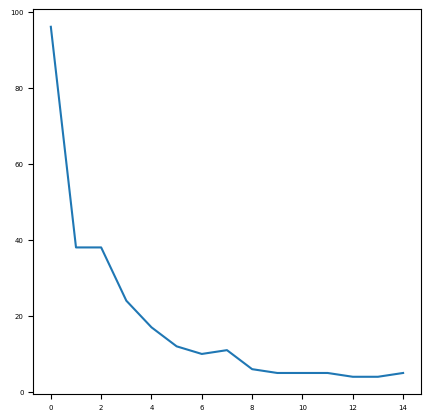

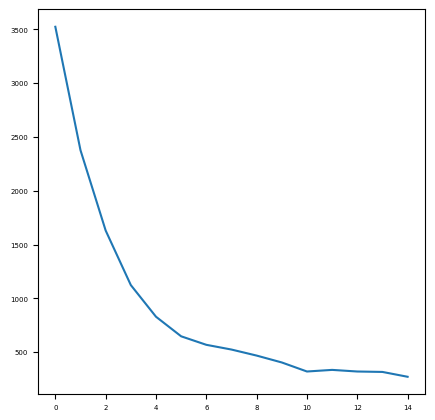

In [11]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 1000
epochs = 15

optimizer = Adam()

loss_function = BinaryCrossentropy()
additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 2.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

plt.figure()
plt.plot(history.history['fp'])
plt.show()

In [12]:
model.save("model.keras")